In [2]:
# start by setting up the environment
using Pkg
using Base.Iterators: partition, repeated
using Statistics

Pkg.activate(@__DIR__)
Pkg.instantiate()
using CSV, ImageMagick, Images # packages for reading data
using Flux # package for machine learning
using Flux: onehotbatch, onecold, crossentropy, throttle, mse
using BSON: @save, @load
using CuArrays, CUDAnative # package for running on Nvidia GPUs
device!(2) # set GPU device id

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Polygon classification using CNN

The task of this project is to classify images of polygons based on how many edges/corners they have.

## Part I

### Data
The dataset consists of a training set and a test set, each consisting of 5000 labeled black and white images. To improve training, we augment the training set by introducing flipped and rotated versions of the images. This gives a new set of 40000 images.

,,,,,,,

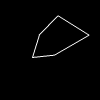
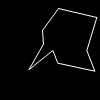
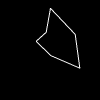
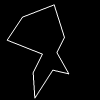
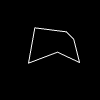
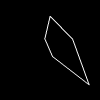
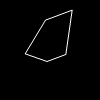
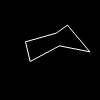

In [3]:
# reads one dataset
function readdata(filename)
  file = CSV.read(filename, delim='\t', header=[:count, :path], types=[Int64, String])
  raw = map(x -> Float64.(Gray.(readblob(read(x)))), file.path)
  x = cat(raw..., dims=4)
  y = file.count
  x, y
end

# augments data with a factor 8 by adding flipped and rotated versions
function augment(X, Y)
  X_aug = cat(X, reverse(X, dims=1), dims=4)
  X_aug = cat(X_aug, reverse(X_aug, dims=2), dims=4)
  X_aug = cat(X_aug, permutedims(X_aug, (2,1,3,4)), dims=4)
  Y_aug = cat(repeated(Y, 8)..., dims=1)
  X_aug, Y_aug
end

# download the data if not already downloaded
isfile("ds1.zip") || download("http://cbbp.thep.lu.se/~mattias/DL/proj-work/ds1.zip", "ds1.zip")

# unzip and read both train and test data
mktempdir() do d
  run(`unzip -q -d $d ds1.zip`)
  cd(joinpath(d, "ds1")) do
    global X_trn, Y_trn, X_tst, Y_tst
    X_trn, Y_trn = readdata("polyAll-trn_trg.csv")
    X_tst, Y_tst = readdata("polyAll-tst_trg.csv")
  end
end

# augment train data
X_trn_aug, Y_trn_aug = augment(X_trn, Y_trn)

# display some examples
display([Gray.(X_trn_aug[:,:,1,i]) for i in 1:8])

### Preprocessing

No preprocessing is done to the images, but rather to the model. This is done by creating filters for the first convolutional layer. The idea is to create filters which capture line-ends of all possible rotations. Note that these filters are only used as initial weights, and will change slightly during model training.

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,

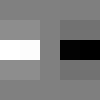
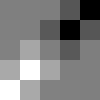
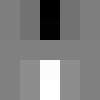
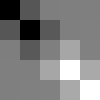
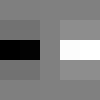
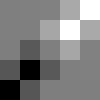
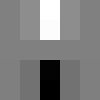
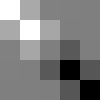
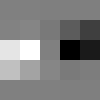
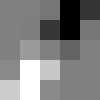
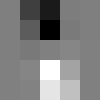
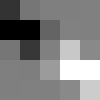
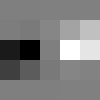
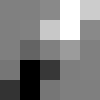
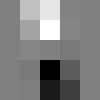
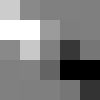
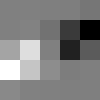
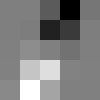
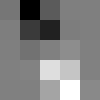
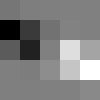
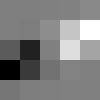
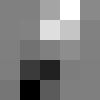
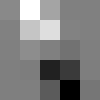
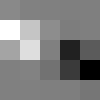
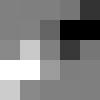
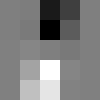
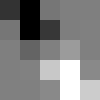
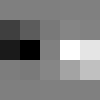
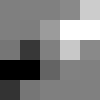
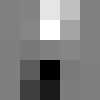
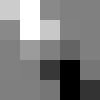
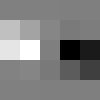

In [4]:
# creates a filter for detecting a line
function linefilter(θ, size; spread=1)
  i = range(-spread, stop=spread, length=size)
  [exp(-(cos(θ)*x+sin(θ)*y)^2) for x in i, y in i]
end

# creates a filter for detecting an edge
function edgefilter(θ, size; spread=1)
  i = range(-spread, stop=spread, length=size)
  [1/(1+exp((cos(θ)*x+sin(θ)*y)*spread)) for x in i, y in i]
end

# creates a filter for detecting the 
function cornerfilter(θ, size; spread=1)
  linefilter(θ, size; spread=spread).*(edgefilter(θ+pi/2, size; spread=spread).-0.5)
end

# normalizes a matrix
function normalize(A, lb=0.0, ub=1.0)
  Amin, Amax = extrema(A)
  (A.-Amin)./(Amax-Amin)*(ub-lb).+lb
end

# create the first-layer filters and display them
rotations = range(0, stop=2*pi, length=32+1)
filters = [cornerfilter(θ, 5, spread=3).*3.0.-0.5 for θ in rotations[1:end-1]]
display(reshape([Gray.(normalize(f)) for f in filters], :, 8))

### Model architecture
The architecture of the model is as follows
* Convolutional, 5x5 filters, 1 to 32 channels, relu activation (this is where we use the pretrained filter weights)
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Max-pooling in a 3x3 window
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Max-pooling in a 3x3 window
* Fully connected, 2592 to 512 values, relu activation
* Dropout, 0.5 probability
* Fully connected, 512 to 8 values, softmax activation

All hidden activation functions are set to relu, which seems to work well. The last layer of the model has 8 values since the training data set has 8 classes of polygons ranging from 3 to 10 corners. The softmax activation function is paired with a crossentropy loss function. Increasing number of filters, changing the activation function or adding more layers does not seem to affect performance after training but leads to increased training time. Without using dropout regularization the model seems to suffer from slight overtraining.

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,

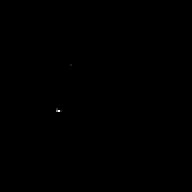
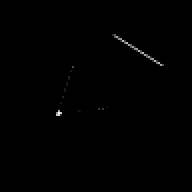
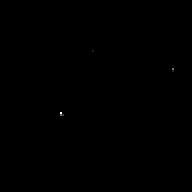
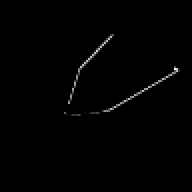
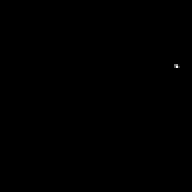
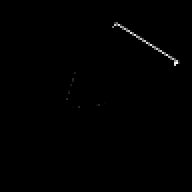
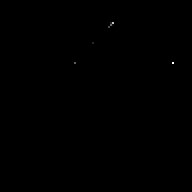
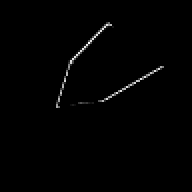
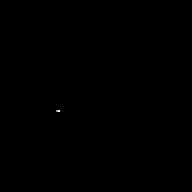
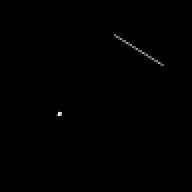
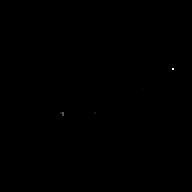
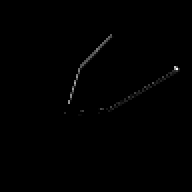
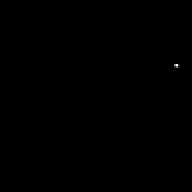
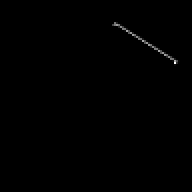
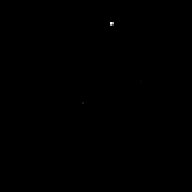
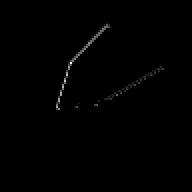
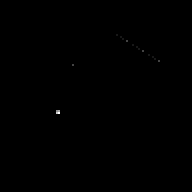
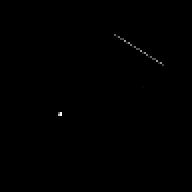
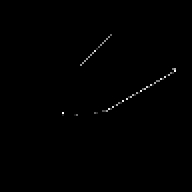
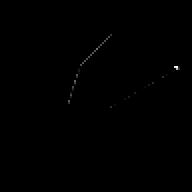
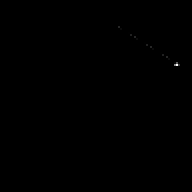
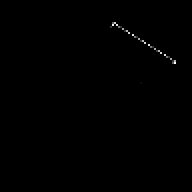
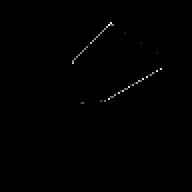
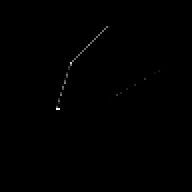
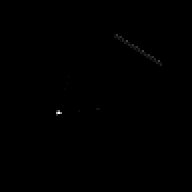
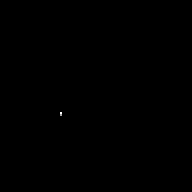
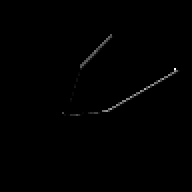
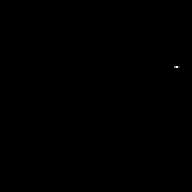
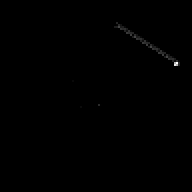
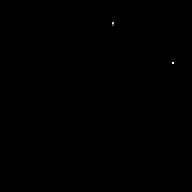
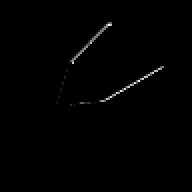
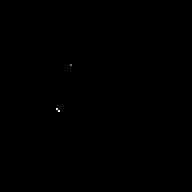

In [5]:
W = param(cat(filters..., dims=4))
b = param(zeros(length(filters)))

model = Chain(
  Conv(W, b, relu),
  Conv((3,3), 32=>32, relu),
  x -> maxpool(x, (3,3)),
  Conv((3,3), 32=>32, relu),
  Conv((3,3), 32=>32, relu),
  x -> maxpool(x, (3,3)),
  x -> reshape(x, :, size(x, 4)),
  Dense(2592, 512, relu),
  Dropout(0.5),
  Dense(512, 8),
  softmax
) |> gpu

# show what the output from the first layer looks like
Z = cpu(model.layers[1](gpu(X_trn_aug[:,:,:,1:1])))
display(reshape([Gray.(normalize(Z[:,:,i,1].data)) for i in 1:size(Z,3)], :, 8))

Move the data to the GPU, and split it into batches with 200 images each.

In [6]:
train = gpu.([(X_trn_aug[:,:,:,i], onehotbatch(Y_trn_aug[i], 3:10)) for i in partition(1:size(X_trn_aug, 4), 200)])
test = gpu.([(X_tst[:,:,:,i], onehotbatch(Y_tst[i], 3:10)) for i in partition(1:size(X_tst, 4), 200)])
;

Train the model. There are no hyper parameters in the loss function. The only thing that needs a bit of manual tweaking is the learning rate. By training with the default training rate most of the epochs and then lower it and continue training, the over all training and testing error decreased.

In [25]:
# define loss and accuracy
loss(x, y) = crossentropy(model(x), y)
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# load pretrained model if it exists
if isfile("full_classification.bson")
  @load "full_classification.bson" m
  model = gpu(m)
else
  # print partial loss and accuracy during training
  evalcb1 = throttle(() -> @show(accuracy(test[1]...)), 10)
  evalcb2 = throttle(() -> @show(loss(train[1]...)), 10)

  # train using default learning rate
  opt = ADAM(params(model), 0.001)
  for i in 1:40
    println("epoch $i")
    Flux.train!(loss, train, opt, cb = [evalcb1, evalcb2])
  end

  # train a bit more using a lower learning rate
  opt = ADAM(params(model), 0.0001)
  for i in 41:50
    println("epoch $i")
    Flux.train!(loss, train, opt, cb = [evalcb1, evalcb2])
  end

  m = cpu(model)
  @save "full_classification.bson" m
end
;

Display final training and testing accuracy, and show what the activations look like after the first max-pooling layer.

"After first maxpool:"

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,

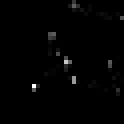
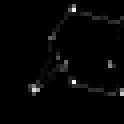
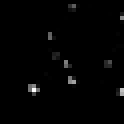
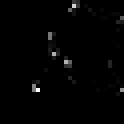
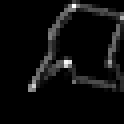
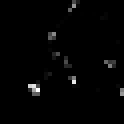
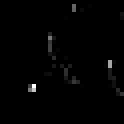
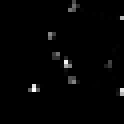
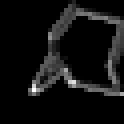
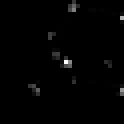
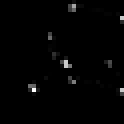
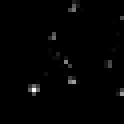
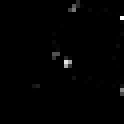
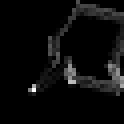
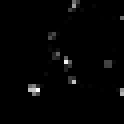
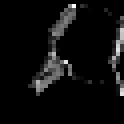
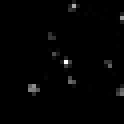
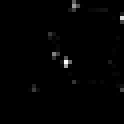
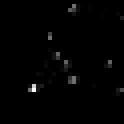
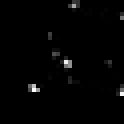
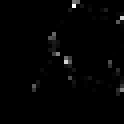
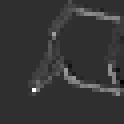
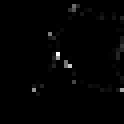
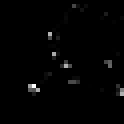
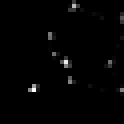
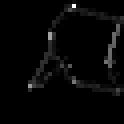
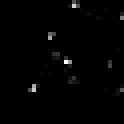
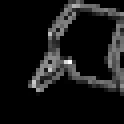
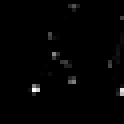
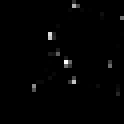
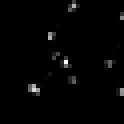
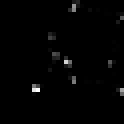

"Before second maxpool:"

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,

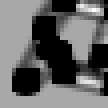
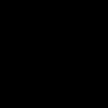
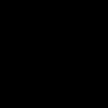
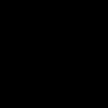
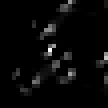
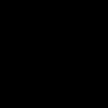
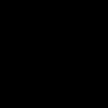
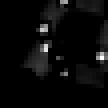
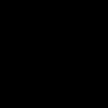
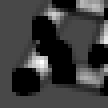
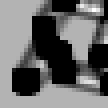
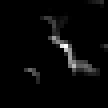
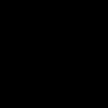
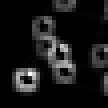
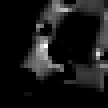
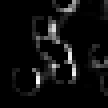
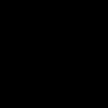
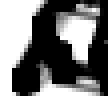
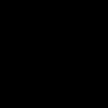
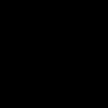
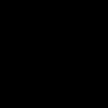
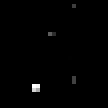
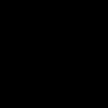
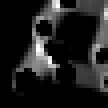
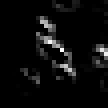
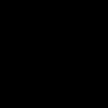
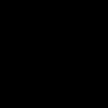
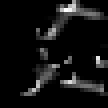
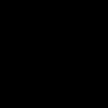
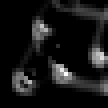
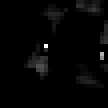
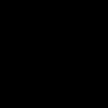

Final training accuracy: 0.995
Final test accuracy: 0.95


In [26]:
Z = cpu(Chain(model.layers[1:3]...)(gpu(X_trn_aug[:,:,:,2:2])))
display("After first maxpool:")
display(reshape([Gray.(normalize(Z[:,:,i,1].data)) for i in 1:size(Z,3)], :, 8))

display("Before second maxpool:")
Z = cpu(Chain(model.layers[1:5]...)(gpu(X_trn_aug[:,:,:,2:2])))
display(reshape([Gray.(normalize(Z[:,:,i,1].data)) for i in 1:size(Z,3)], :, 8))

train_accuracy = mean(x->accuracy(x...), train)
test_accuracy = mean(x->accuracy(x...), test)

println("Final training accuracy: $(round(train_accuracy, digits=3))")
println("Final test accuracy: $(round(test_accuracy, digits=3))")

If we want to have a regression model instead, we can replace the last layer of the model with a fully connected layer with a single output and a linear activation function. We will also remove the dropout layer. It works quite well to just let the training optimize the parameters for the new last layer, without doing further optimizations to the rest of the model. The architecture of the regression model is as follows
* Block 1 (will not be trained further)
    * Convolutional, 5x5 filters, 1 to 32 channels, relu activation
    * Convolutional, 3x3 filters, 32 to 32 channels, relu activation
    * Max-pooling in a 3x3 window
    * Convolutional, 3x3 filters, 32 to 32 channels, relu activation
    * Convolutional, 3x3 filters, 32 to 32 channels, relu activation
    * Max-pooling in a 3x3 window
    * Fully connected, 2592 to 512 values, relu activation
* Block 2 (will be trained)
    * Fully connected, 512 to 1 values, linear activation
In order to train this model we use a MSE loss function.

Transform the data using a partial model, then move the data to the GPU and split it into batches with 400 images each.

In [27]:
partial = Chain(model.layers[1:end-3]...) |> gpu
train_reg = ([(partial(gpu(X_trn_aug[:,:,:,i])).data, gpu(reshape(Y_trn_aug[i], 1, :))) for i in partition(1:size(X_trn_aug, 4), 400)])
test_reg = ([(partial(gpu(X_tst[:,:,:,i])).data, gpu(reshape(Y_tst[i], 1, :))) for i in partition(1:size(X_tst, 4), 400)])
;

In [28]:
model_reg = Chain(
  Dense(512, 1),
  identity
) |> gpu

loss(x, y) = mse(model_reg(x), y)
accuracy(x, y) = mean(round.(model_reg(x)) .== y)

evalcb1 = throttle(() -> @show(accuracy(test_reg[1]...)), 5)
evalcb2 = throttle(() -> @show(loss(train_reg[1]...)), 5)
opt = ADAM(params(model_reg), 0.0005)
for i in 1:500
  Flux.train!(loss, train_reg, opt, cb=[evalcb1, evalcb2])
end

accuracy(test_reg[1]...) = 0.0
loss(train_reg[1]...) = 93.108f0 (tracked)
accuracy(test_reg[1]...) = 0.885
loss(train_reg[1]...) = 0.081718296f0 (tracked)
accuracy(test_reg[1]...) = 0.9175
loss(train_reg[1]...) = 0.062190186f0 (tracked)
accuracy(test_reg[1]...) = 0.9325
loss(train_reg[1]...) = 0.053730693f0 (tracked)
accuracy(test_reg[1]...) = 0.95
loss(train_reg[1]...) = 0.047415953f0 (tracked)


In [29]:
train_accuracy = mean(x->accuracy(x...), train_reg)
test_accuracy = mean(x->accuracy(x...), test_reg)

println("Final training accuracy: $(round(train_accuracy, digits=3))")
println("Final test accuracy: $(round(test_accuracy, digits=3))")

Final training accuracy: 0.969
Final test accuracy: 0.954


## Part II

This part is a version of the previous, but now the training data only includes odd numbered polygons while the test data only includes even numbered polygons. All steps will be performed in a similar way as the previous part.

### Data

,,,,,,,

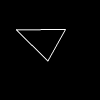
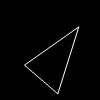
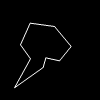
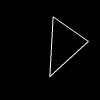
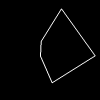
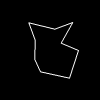
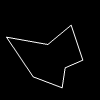
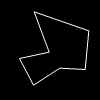

In [39]:
# download the data if not already downloaded
isfile("ds2.zip") || download("http://cbbp.thep.lu.se/~mattias/DL/proj-work/ds2.zip", "ds2.zip")

# unzip and read both train and test data
mktempdir() do d
  run(`unzip -q -d $d ds2.zip`)
  cd(joinpath(d, "ds2")) do
    global X_trn, Y_trn, X_tst, Y_tst
    X_trn, Y_trn = readdata("polyOdd-trn_trg.csv")
    X_tst, Y_tst = readdata("polyEven-tst_trg.csv")
  end
end

# augment train data
X_trn_aug, Y_trn_aug = augment(X_trn, Y_trn)

# display some examples
display([Gray.(X_trn_aug[:,:,1,i]) for i in 1:8])

### Model architecture
The architecture of the model is the same as in the first part, except now we only have 4 classes
* Convolutional, 5x5 filters, 1 to 32 channels, relu activation (this is where we use the pretrained filter weights)
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Max-pooling in a 3x3 window
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Convolutional, 3x3 filters, 32 to 32 channels, relu activation
* Max-pooling in a 3x3 window
* Fully connected, 2592 to 512 values, relu activation
* Dropout, 0.5 probability
* Fully connected, 512 to 4 values, softmax activation

In [42]:
W = param(cat(filters..., dims=4))
b = param(zeros(length(filters)))

model = Chain(
  Conv(W, b, relu),
  Conv((3,3), 32=>32, relu),
  x -> maxpool(x, (3,3)),
  Conv((3,3), 32=>32, relu),
  Conv((3,3), 32=>32, relu),
  x -> maxpool(x, (3,3)),
  x -> reshape(x, :, size(x, 4)),
  Dense(2592, 512, relu),
  Dropout(0.5),
  Dense(512, 4),
  softmax
) |> gpu
;

Move the data to the GPU, and split it into batches with 200 images each. Note that as test set we temporarily use the first 5 batches of the training data.

In [44]:
train = gpu.([(X_trn_aug[:,:,:,i], onehotbatch(Y_trn_aug[i], 3:2:9)) for i in partition(1:size(X_trn_aug, 4), 200)])
test = train[1:5]
train = train[6:end]
;

In [49]:
# define loss and accuracy
loss(x, y) = crossentropy(model(x), y)
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# load pretrained model if it exists
if isfile("odd_classification.bson")
  @load "odd_classification.bson" m
  model = gpu(m)
else
  # print partial loss and accuracy during training
  evalcb1 = throttle(() -> @show(accuracy(test[1]...)), 10)
  evalcb2 = throttle(() -> @show(loss(train[1]...)), 10)

  # train using default learning rate
  opt = ADAM(params(model), 0.001)
  for i in 1:25
    println("epoch $i")
    Flux.train!(loss, train, opt, cb = [evalcb1, evalcb2])
  end

  m = cpu(model)
  @save "odd_classification.bson" m
end
;

In [50]:
train_accuracy = mean(x->accuracy(x...), train)
test_accuracy = mean(x->accuracy(x...), test)

println("Final training accuracy: $(round(train_accuracy, digits=3))")
println("Final test accuracy: $(round(test_accuracy, digits=3))")

Final training accuracy: 0.992
Final test accuracy: 0.977


Transform the data using a partial model, then move the data to the GPU and split it into batches with 400 images each.

In [52]:
partial = Chain(model.layers[1:end-3]...) |> gpu
train_reg = ([(partial(gpu(X_trn_aug[:,:,:,i])).data, gpu(reshape(Y_trn_aug[i], 1, :))) for i in partition(1:size(X_trn_aug, 4), 400)])
test_reg = ([(partial(gpu(X_tst[:,:,:,i])).data, gpu(reshape(Y_tst[i], 1, :))) for i in partition(1:size(X_tst, 4), 400)])
;

In [65]:
model_reg = Chain(
  Dense(512, 1),
  identity
) |> gpu

loss(x, y) = mse(model_reg(x), y)
accuracy(x, y) = mean(round.(model_reg(x)) .== y)

evalcb1 = throttle(() -> @show(accuracy(test_reg[1]...)), 5)
evalcb2 = throttle(() -> @show(accuracy(train_reg[1]...)), 5)
opt = ADAM(params(model_reg), 0.0005)
for i in 1:2000
  Flux.train!(loss, train_reg, opt, cb=[evalcb1, evalcb2])
end

accuracy(test_reg[1]...) = 0.0025
accuracy(train_reg[1]...) = 0.0525
accuracy(test_reg[1]...) = 0.61
accuracy(train_reg[1]...) = 0.735
accuracy(test_reg[1]...) = 0.7025
accuracy(train_reg[1]...) = 0.7775
accuracy(test_reg[1]...) = 0.685
accuracy(train_reg[1]...) = 0.8075
accuracy(test_reg[1]...) = 0.6875
accuracy(train_reg[1]...) = 0.8275
accuracy(test_reg[1]...) = 0.68
accuracy(train_reg[1]...) = 0.8375
accuracy(test_reg[1]...) = 0.6925
accuracy(train_reg[1]...) = 0.8175
accuracy(test_reg[1]...) = 0.6575
accuracy(train_reg[1]...) = 0.845
accuracy(test_reg[1]...) = 0.66
accuracy(train_reg[1]...) = 0.845
accuracy(test_reg[1]...) = 0.6675
accuracy(train_reg[1]...) = 0.85
accuracy(test_reg[1]...) = 0.6625
accuracy(train_reg[1]...) = 0.8425
accuracy(test_reg[1]...) = 0.655
accuracy(train_reg[1]...) = 0.8475
accuracy(test_reg[1]...) = 0.695
accuracy(train_reg[1]...) = 0.8325
accuracy(test_reg[1]...) = 0.68
accuracy(train_reg[1]...) = 0.845
accuracy(test_reg[1]...) = 0.66
accuracy(train_reg[

In [67]:
train_accuracy = mean(x->accuracy(x...), train_reg)
test_accuracy = mean(x->accuracy(x...), test_reg)

println("Final training accuracy: $(round(train_accuracy, digits=3))")
println("Final test accuracy: $(round(test_accuracy, digits=3))")

Final training accuracy: 0.861
Final test accuracy: 0.686


## Summary

A quick summary of the achieved accuracies

<table align="left">
  <tr>
    <th></th>
    <th colspan="2">Classification</th>
    <th colspan="2">Regression</th>
  </tr>
  <tr>
    <th></th>
    <th>Training</th>
    <th>Validation</th>
    <th>Training</th>
    <th>Validation</th>
  </tr>
  <tr>
    <th>Part I</th>
    <td>0.995</td>
    <td>0.95</td>
    <td>0.969</td>
    <td>0.954</td>
  </tr>
  <tr>
    <th>Part I</th>
    <td>0.992</td>
    <td>0.977</td>
    <td>0.861</td>
    <td>0.686</td>
  </tr>
</table>